In [6]:
# packages setup
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")
import scanpy as sc, anndata as ad
import leidenalg
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

[i'm dying](https://towardsdatascience.com/t-sne-from-scratch-ft-numpy-172ee2a61df7)

**steps**:
1. get similarity matrix between points in original (high dimensional) space
    - get conditional probabilities for each point relative to all other points using a Gaussian  
2. initialization
    - chose random starting points in the lower-dimensional space for each original datapoint and compute a new probability matrix using a Student t-distribution rather than a Guassian, but in the lower dimensional space  
3. mapping 
    - minimize Kullback-Liebler divergence between joint probabilities --> minimize the differences in the probabilities between the similarity matrices of the two spaces

In [1]:
# STEP 1 
# get pairwise distances
def get_pairwise_dist(X):
    return squareform(pdist(X, 'euclidean'))

search space defined by [0.01 * standard deviation of the norms for the difference between images i and j, 5 * standard deviation of the norms for the difference between images i and j] divided into 200 equal steps. 

In [17]:
# STEP 2b
# perform grid search to obtain values of sigma based on perplexity (used to get similarities)
def search_sigma(distances, curr, perplexity):
    """
    Obtain σ's based on user's perplexity value.

    Parameters:
        distances (np.ndarray): Array containing the pairwise distances between data points.
        curr (int): Index of current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        sig (float): The value of σ that satisfies the perplexity condition.
    """
    # initialize result as infinity
    result = np.inf
    
    norm = np.linalg.norm(distances, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # numerator
        num = np.exp(-(norm**2) / (2 * search**2))

        # Set p = 0 when i = j
        num[curr] = 0

        # equation 1 (ε -> 0)
        eps = np.nextafter(0, 1)
        p_new = np.maximum(num / np.sum(num), eps)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close as possible to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            sig = search

    return sig

In [19]:
# STEP 2a
# compute affinities matrix for X in the original (high-dimensional) space
def get_highdim_affinities(X, perplexity):
    """
    Function to obtain similarities matrix in original high-dimensional space.

    Parameters:
    X (??): The input AnnData object no
    perplexity (int): Perplexity of the joint probability distribution

    Returns:
    P (np.ndarray of shape (number of samples * (num samples - 1) / 2)): Joint probabilities  matrix.
    """ 
    n = len(X)
    P = np.zeros((n, n))
    
    for i in range(0, n):
        # equation 1 numerator
        difference = X[i] - X
        sig_i = search_sigma(difference, i, perplexity) # call search function to get sigma
        norm = np.linalg.norm(difference, axis=1)
        P[i, :] = np.exp(-(norm**2) / (2 * sig_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(P, 0)

        # compute equation 1
        P[i, :] = P[i, :] / np.sum(P[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    P = np.maximum(P, eps)

#     print("Completed Pairwise Affinities Matrix. \n")

    return P

In [24]:
# STEP 2c
# convert original affinities matrix into joint probabilities (symmetric) affinities matrix
def convert_to_jointprob(P):
    """
    Obtain symmetric affinities matrix from original affinities matrix to be utilized in t-SNE.

    Parameters:
    P (np.ndarray): Input (original) affinity matrix.

    Returns:
    P_symmetric (np.ndarray): Symmetric affinities matrix.

    """
    n = len(P)
    P_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            P_symmetric[i, j] = (P[i, j] + P[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    P_symmetric = np.maximum(P_symmetric, eps)

    return P_symmetric

In [27]:
# STEP 3a
# sample initial solution in lower-dimensional space
def initialize(X, n_dim: int = 2, initialization: str = "random"):
    """
    Create initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        initialization (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        soln (np.ndarray): The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # sample initial solution 
    if initialization == "random" or initialization != "PCA":
        soln = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dim))
    elif initialization == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        soln = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return soln

In [34]:
# STEP 3b
# compute affinity matrix in lower-dimensional space
# use a Student t-distribution with 1 df
def get_lowdim_affinities(Y):
    """
    Obtain low-dimensional affinities.

    Parameters:
    Y (np.ndarray): Low-dimensional representation of the data points.

    Returns:
    Q (np.ndarray): The low-dimensional affinities matrix.
    """

    n = len(Y)
    Q = np.zeros(shape=(n, n))

    for i in range(0, n):
        # equation 4 numerator
        difference = Y[i] - Y
        norm = np.linalg.norm(difference, axis=1)
        Q[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(Q, 0)

    # equation 4
    Q = Q / Q.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    Q = np.maximum(Q, eps)

    return Q

In [39]:
# STEP 4
# compute gradient of the cost function 
# cost function = Kullback-Leibler divergence btwn joint prob distrs in
# high dimensional space/low dimensional space
def compute_gradient(P, Q, Y):
    """
    Obtain gradient of cost function at current point Y.

    Parameters:
    P (np.ndarray): The joint probability distribution matrix.
    Q (np.ndarray): The Student's t-distribution matrix.
    Y (np.ndarray): The current point in the low-dimensional space.

    Returns:
    gradient (np.ndarray): The gradient of the cost function at the current point Y.
    """

    n = len(P)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        difference = Y[i] - Y
        A = np.array([(P[i, :] - Q[i, :])])
        B = np.array([(1 + np.linalg.norm(difference, axis=1)) ** (-1)])
        C = difference
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [59]:
# STEP 5: t-SNE
# iterate and optimize low-dimensional mapping
# use gradient descent with momentum
# learning rate controls step size at each iteration
# momentum allows optimization algorithm to gain inertia within search space idk what that means
def diSNE(adata, perplexity, T, learning_rate: int = 200, early_exaggeration: int = 4, n_dim: int = 2):
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Args:
        X (np.ndarray): The input data matrix of shape (n_samples, n_features).
        perplexity (int, optional): The perplexity parameter. Default is 10.
        T (int, optional): The number of iterations for optimization. Default is 1000.
        learning_rate (int, optional): The learning rate for updating the low-dimensional embeddings. Default is 200.
        early_exaggeration (int, optional): The factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dim (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.

    Returns:
        list[np.ndarray, np.ndarray]: A list containing the final low-dimensional embeddings and the history
            of embeddings at each iteration.

    """
    X = adata.X
    n = len(X)

    # Get original affinities matrix
    P = get_highdim_affinities(X, perplexity)
    P_symmetric = convert_to_jointprob(P)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dim))
    Y_minus1 = np.zeros(shape=(n, n_dim))
    Y[0] = Y_minus1
    Y1 = initialize(X, n_dim)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            momentum = 0.5
            early_exaggeration = early_exaggeration
        else:
            momentum = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        Q = get_lowdim_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = compute_gradient(early_exaggeration * P_symmetric, Q, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - learning_rate * gradient + momentum * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 100 == 0:
            cost = np.sum(P_symmetric * np.log(P_symmetric / Q))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    soln = Y[-1]

#     return soln, Y
    adata.obsm['X_tsne'] = soln
    return

In [13]:
# test
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import pandas as pd

# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_total = pd.DataFrame(mnist["data"])
y_total = pd.DataFrame(mnist["target"])

X_reduced = X_total.sample(n=1000)
y_reduced = y_total.loc[X_total.index]

# PCA to keep 30 components
X = PCA(n_components=30).fit_transform(X_reduced) 

In [23]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,928.820918,-133.739365,-310.624434,-145.422847,-1040.086867,-268.385860,428.608781,-538.422060,150.542792,-103.956557,...,-199.902756,311.633718,88.771998,53.353268,-200.583911,-97.713765,164.078212,307.136196,100.432952,-127.804101
1,814.781808,1050.417786,-452.738365,-459.170021,-548.020787,-176.240957,-169.810230,387.870785,242.134639,637.548003,...,-144.761985,-274.239532,-90.471784,75.649522,-83.228285,307.966724,-121.498102,-345.731699,-306.742996,-252.329654
2,339.047952,-894.209072,144.010055,-513.400501,310.000242,86.703854,-29.756196,-34.821684,-69.572670,-340.292626,...,-120.504963,302.335014,-266.147111,386.829429,-44.701521,-212.744435,104.980515,-188.430760,-171.747378,77.839412
3,-83.734808,-914.640996,-638.220274,285.851849,-156.783764,-299.651565,82.505056,355.510760,257.512990,-310.620212,...,93.532712,365.176999,182.055427,-396.521475,36.450843,-375.719295,5.041417,-45.383561,-4.897939,238.054750
4,357.614489,-776.074678,-688.094764,-487.879727,34.079845,171.522526,765.227798,186.699525,-428.999981,-303.240668,...,-71.280082,-191.946759,-189.960325,-4.561916,5.937298,0.081370,99.663823,-52.339930,174.115552,-100.186728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-341.414275,79.518930,-741.568565,183.298542,50.487908,-511.769231,125.877661,127.209512,-96.054436,54.895602,...,-201.582749,25.270585,66.600707,209.195685,-22.112669,149.991562,-19.820902,-80.645902,-37.059288,-210.300018
996,321.086012,-173.511997,558.932602,179.600945,122.921747,-186.807383,-337.858697,-173.303541,311.095411,39.868550,...,-289.303009,207.797512,-228.237339,195.608914,-198.273198,132.607645,119.816978,305.847128,-330.781698,90.984555
997,-385.051935,-279.257413,247.778610,184.834742,-97.973289,-558.158009,-718.619267,-25.729808,11.888254,515.963033,...,-134.190333,-154.590671,175.645350,-230.494083,-39.517717,214.165262,-108.661235,-151.250716,166.743913,56.948593
998,1397.913328,118.946563,65.339449,-365.295109,394.403103,127.340297,220.700595,-73.450503,-280.316489,-280.124471,...,-180.881914,-204.301226,46.547144,-54.721964,-132.513308,233.632862,45.317698,-129.222321,13.806798,93.314916


In [22]:
p_ij = get_highdim_affinities(X, 10)
pd.DataFrame(p_ij)

/tmp/ipykernel_3023/462108980.py:30: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.maximum(num / np.sum(num), eps)


Completed Pairwise Affinities Matrix. 



,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,4.940656e-324,3.455480e-07,1.010117e-05,5.171067e-06,9.132362e-05,2.119219e-07,1.206060e-07,1.530822e-08,2.086812e-07,8.996827e-09,...,1.681262e-07,1.017902e-07,1.081355e-01,7.214335e-08,1.731116e-07,5.873337e-07,4.850998e-06,1.667662e-07,1.842416e-05,1.216228e-08
1,3.269814e-06,4.940656e-324,9.162141e-08,2.757564e-08,5.494688e-08,2.375863e-05,9.122110e-05,2.302146e-07,9.450355e-09,1.638014e-07,...,1.058133e-07,3.464310e-07,1.049941e-03,7.840148e-09,7.074126e-08,4.214339e-05,7.270669e-07,9.503442e-06,1.215706e-05,2.454414e-07
2,5.173268e-09,3.195602e-14,4.940656e-324,1.283294e-06,1.814244e-04,6.602099e-10,4.561897e-11,4.693387e-09,1.054590e-10,7.211086e-08,...,7.948672e-07,2.843586e-12,7.797501e-12,2.716113e-09,3.119855e-05,3.292864e-09,2.412395e-07,1.071781e-08,6.588183e-07,3.608175e-08
3,3.068377e-10,5.433708e-16,2.255750e-07,4.940656e-324,1.860590e-06,1.397560e-05,6.424848e-09,1.469948e-09,5.320865e-09,1.010885e-09,...,1.693411e-06,1.754060e-09,1.386846e-11,3.299491e-11,1.294974e-05,1.713390e-07,1.873417e-09,6.150356e-07,5.920556e-12,3.977625e-09
4,5.818303e-07,1.501402e-12,1.398193e-04,1.496608e-05,4.940656e-324,6.585892e-08,1.075064e-07,1.478516e-09,2.871652e-11,6.777239e-09,...,2.902217e-05,1.054771e-10,1.109280e-08,3.369412e-08,2.102471e-04,5.095463e-07,9.329710e-10,9.689928e-10,1.091575e-05,2.682085e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.424308e-12,1.828821e-10,2.054289e-10,2.294559e-07,2.099812e-08,2.761406e-07,1.890901e-03,8.775224e-07,5.603315e-12,1.507413e-06,...,4.815911e-07,3.770831e-14,1.000137e-08,1.905111e-12,1.712633e-07,4.940656e-324,1.350647e-08,4.246267e-07,1.783913e-14,8.445331e-14
996,2.611742e-09,9.472339e-13,7.652368e-07,2.266421e-08,4.436555e-11,1.472955e-08,2.638495e-07,5.996061e-07,1.928312e-09,8.870019e-07,...,6.769632e-06,1.354207e-10,1.708945e-09,1.052580e-06,3.408875e-08,2.753480e-07,4.940656e-324,1.052235e-05,1.537055e-09,1.525600e-08
997,1.479466e-13,4.714626e-12,4.119970e-10,2.418404e-07,1.045488e-12,2.984877e-08,2.349552e-06,7.146871e-05,3.304760e-11,1.253254e-05,...,8.939491e-07,2.842462e-10,4.702736e-12,2.225425e-10,2.648813e-08,1.031719e-07,1.620389e-07,4.940656e-324,1.432547e-12,3.536778e-08
998,2.073083e-08,5.742320e-10,8.108182e-07,7.845912e-11,7.485202e-06,2.322988e-11,6.657229e-12,3.183095e-11,3.938215e-13,1.300277e-11,...,2.492739e-10,1.692208e-10,1.238406e-09,1.278966e-07,4.098648e-11,4.455222e-12,1.850988e-09,1.349190e-10,4.940656e-324,3.090133e-08


In [25]:
p_ij_symmetric = convert_to_jointprob(p_ij)
pd.DataFrame(p_ij_symmetric)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,4.940656e-324,1.807681e-09,5.053171e-09,2.585687e-09,4.595273e-08,1.060449e-10,6.172752e-11,7.654108e-12,3.739440e-10,4.498413e-12,...,8.406308e-11,1.492608e-09,1.066938e-04,3.610426e-11,8.655581e-11,2.936676e-10,2.426805e-09,8.338316e-11,9.222448e-09,6.338044e-12
1,1.807681e-09,4.940656e-324,4.581072e-11,1.378782e-11,2.747419e-11,1.188476e-08,4.613063e-08,1.151073e-10,5.286907e-12,8.190069e-11,...,5.290666e-11,7.089318e-10,5.279826e-07,3.920105e-12,3.537063e-11,2.107178e-08,3.635339e-10,4.751723e-09,6.078819e-09,1.230807e-10
2,5.053171e-09,4.581072e-11,4.940656e-324,7.544346e-10,1.606219e-07,3.937311e-12,7.696671e-12,2.346694e-12,1.045064e-09,3.605543e-11,...,3.974467e-10,1.286578e-09,1.270350e-14,1.059607e-11,1.569412e-08,1.749146e-12,5.032381e-10,5.564904e-12,7.348182e-10,3.930457e-09
3,2.585687e-09,1.378782e-11,7.544346e-10,4.940656e-324,8.413333e-09,2.016472e-07,1.168009e-09,7.349738e-13,3.334133e-08,5.054425e-13,...,8.472611e-10,4.602704e-08,1.158780e-13,1.171341e-12,6.734035e-09,2.003975e-10,1.226881e-11,4.284380e-10,4.218984e-14,2.776183e-09
4,4.595273e-08,2.747419e-11,1.606219e-07,8.413333e-09,4.940656e-324,7.979314e-11,7.658349e-10,7.392582e-13,4.147831e-11,3.388620e-12,...,1.451337e-08,1.276887e-09,7.204482e-12,3.033813e-11,1.065766e-07,2.652722e-10,4.886683e-13,4.850191e-13,9.200477e-09,6.618066e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.936676e-10,2.107178e-08,1.749146e-12,2.003975e-10,2.652722e-10,3.898388e-09,4.175985e-06,4.387612e-10,1.435268e-09,7.537063e-10,...,2.408398e-10,1.330983e-09,1.641422e-10,5.361552e-13,8.676264e-11,4.940656e-324,1.444273e-10,2.638993e-10,2.236530e-15,4.831571e-12
996,2.426805e-09,3.635339e-10,5.032381e-10,1.226881e-11,4.886683e-13,4.201240e-11,2.475963e-09,2.998030e-10,4.715038e-09,4.435009e-10,...,3.384855e-09,6.612887e-09,2.610385e-12,9.264316e-10,1.705504e-11,1.444273e-10,4.940656e-324,5.342194e-09,1.694022e-12,1.201362e-09
997,8.338316e-11,4.751723e-09,5.564904e-12,4.284380e-10,4.850191e-13,1.837652e-09,1.651875e-07,3.573435e-08,4.334377e-09,6.266271e-09,...,4.477015e-10,4.057944e-08,2.600688e-13,1.769133e-11,1.386796e-11,2.638993e-10,5.342194e-09,4.940656e-324,6.817576e-14,3.430902e-08
998,9.222448e-09,6.078819e-09,7.348182e-10,4.218984e-14,9.200477e-09,8.195401e-14,8.918276e-13,1.591548e-14,1.731116e-11,6.501386e-15,...,1.246370e-13,5.535645e-09,1.627181e-12,2.140624e-10,2.049644e-14,2.236530e-15,1.694022e-12,6.817576e-14,4.940656e-324,2.539505e-09


In [29]:
y0 = initialize(X) #random starting solution
pd.DataFrame(y0)

,0,1
0,-0.000045,-0.000022
1,-0.000024,-0.000032
2,-0.000011,0.000101
3,-0.000105,-0.000093
4,-0.000076,0.000014
...,...,...
995,0.000048,0.000068
996,-0.000120,0.000120
997,0.000033,-0.000051
998,0.000242,0.000157


In [35]:
# 1000x1000 affinity matrix but in lower dimensional space
q_ij = get_lowdim_affinities(y0)
pd.DataFrame(q_ij)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,4.940656e-324,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06
1,1.001001e-06,4.940656e-324,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06
2,1.001001e-06,1.001001e-06,4.940656e-324,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06
3,1.001001e-06,1.001001e-06,1.001001e-06,4.940656e-324,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06
4,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,4.940656e-324,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,4.940656e-324,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06
996,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,4.940656e-324,1.001001e-06,1.001001e-06,1.001001e-06
997,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,4.940656e-324,1.001001e-06,1.001001e-06
998,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,1.001001e-06,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,1.001001e-06,1.001001e-06,1.001001e-06,4.940656e-324,1.001001e-06


In [40]:
# gradient at y0
gradient = compute_gradient(p_ij_symmetric, q_ij, y0)
pd.DataFrame(gradient)

,0,1
0,6.161239e-08,1.660070e-07
1,9.308465e-08,1.330694e-07
2,-9.046396e-08,7.265698e-08
3,-1.594658e-07,1.828953e-08
4,-1.734733e-07,1.902616e-07
...,...,...
995,-1.432804e-07,-5.728946e-08
996,1.829704e-07,-1.695480e-07
997,-1.169553e-07,1.272533e-07
998,2.174397e-07,-2.011760e-07


In [44]:
solution, Y = diSNE(X, 10, 1000, 4, 2)

/tmp/ipykernel_3023/462108980.py:30: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.maximum(num / np.sum(num), eps)


Completed Pairwise Affinities Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 4.437163115247272
Iteration 50: Value of Cost Function is 4.437163021818647
Iteration 100: Value of Cost Function is 4.4371624593874675
Iteration 150: Value of Cost Function is 4.437156322906942
Iteration 200: Value of Cost Function is 4.437080257619082
Iteration 250: Value of Cost Function is 4.43611417423406
Iteration 300: Value of Cost Function is 4.321208506428796
Iteration 350: Value of Cost Function is 3.7063223611120946
Iteration 400: Value of Cost Function is 3.2389992965666545
Iteration 450: Value of Cost Function is 2.932033756201411
Iteration 500: Value of Cost Function is 2.7123031966266047
Iteration 550: Value of Cost Function is 2.547001885189076
Iteration 600: Value of Cost Function is 2.4171875766151407
Iteration 650: Value of Cost Function is 2.3113798346204923
Iteration 700: Value of Cost Function is 2.2224001962468862
Iteration 750: Value of Cost Fu

In [47]:
pd.DataFrame(solution)

,0,1
0,9.592435,2.551861
1,13.316041,-0.810794
2,3.084042,7.391381
3,1.942779,-1.137564
4,5.873279,10.759889
...,...,...
995,9.763966,-5.819767
996,-3.156348,-3.582260
997,-1.182660,11.969967
998,-9.366154,-3.158777


Shape of the data: (300, 10)
Shape of the labels: (300,)


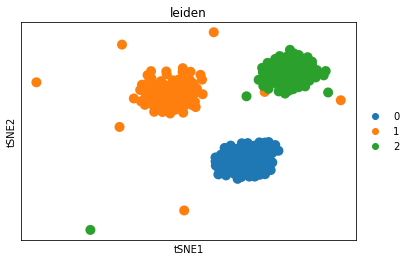

In [52]:
# Generate synthetic data
n_samples = 300
n_features = 10
n_clusters = 3

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

# Display the synthetic data
print("Shape of the data:", X.shape)
print("Shape of the labels:", y.shape)

# Create an AnnData object
adata = sc.AnnData(X)
adata.obs['labels'] = pd.Categorical(y)

# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')

# Run Leiden clustering
sc.tl.leiden(adata, resolution=1.0)

# Run t-SNE
sc.tl.tsne(adata)
# Plot the t-SNE results
sc.pl.tsne(adata, color='leiden')


In [53]:
def plot_tsne_results(adata, feature, title='t-SNE results', figsize=(10, 8)):
    tsne_out = adata.obsm['X_tsne']
    labels = adata.obs[feature].astype(int).values
    plt.figure(figsize=figsize)
    scatter = plt.scatter(tsne_out[:, 0], tsne_out[:, 1], c=labels, cmap='viridis', marker='o')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar()
    plt.show()

In [60]:
diSNE(adata, 10, 1000, 4, 2)

/tmp/ipykernel_3023/462108980.py:30: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.maximum(num / np.sum(num), eps)


Completed Pairwise Affinities Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 100: Value of Cost Function is 3.042347464458155
Iteration 200: Value of Cost Function is 2.1851077401939425
Iteration 300: Value of Cost Function is 1.574949719604962
Iteration 400: Value of Cost Function is 1.2668863971395619
Iteration 500: Value of Cost Function is 1.153652689633076
Iteration 600: Value of Cost Function is 1.094293064766231
Iteration 700: Value of Cost Function is 1.057293653497896
Iteration 800: Value of Cost Function is 1.0315530758436184
Iteration 900: Value of Cost Function is 1.0125072992476096
Completed Low Dimensional Embedding: Final Value of Cost Function is 4.437163115961609


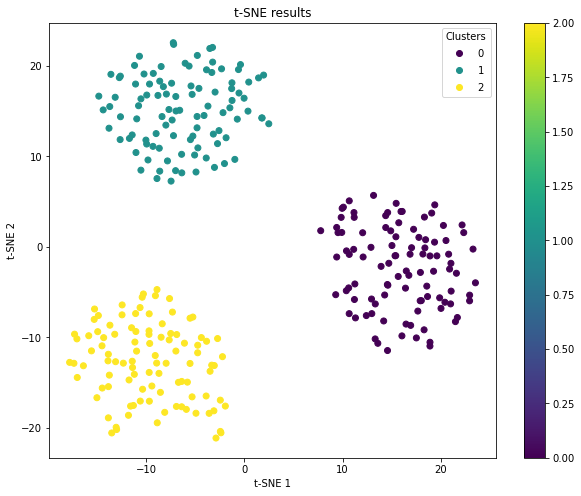

In [61]:
# Extract t-SNE results and cluster labels
tsne_out = adata.obsm['X_tsne']
clusters = adata.obs['leiden'].astype(int).values  # Cluster labels

# Plot the t-SNE results
plot_tsne_results(adata, feature='leiden')